<a href="https://colab.research.google.com/github/FagerholmEmil/FagerholmEmil/blob/main/UNETR1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch 
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR, MultiplicativeLR
from torchvision import transforms
import torch.optim as optim

import copy
import math
import matplotlib as plt

import numpy as np
import pandas as pd

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.model_selection import train_test_split

import glob

from PIL import Image

import random

import cv2

from tqdm import tqdm

from time import sleep

from collections import OrderedDict, defaultdict 

import warnings
warnings.filterwarnings('ignore')

In [ ]:
GPU = True
device = "cuda" if GPU and torch.cuda.is_available() else "cpu"

print(f'Using device {device}')

Using device cpu


# Final

In [ ]:
!git clone https://github.com/FagerholmEmil/openbio.git
!mv openbio/unetr.py . # get the helper_functions.py script
!rm -rf openbio

Cloning into 'openbio'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 34 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (34/34), 457.52 KiB | 8.97 MiB/s, done.


In [ ]:
from unetr import UNETR
demo_img = torch.randn(1, 3, 224, 224).to(device)

unetr = UNETR(img_shape=(224, 224),
              input_dim=3,
              output_dim=1,
              embed_dim=768,
              patch_size=16,
              num_heads=12,
              dropout=0.1
              ).to(device)

summary(model=UNETR(),
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
UNETR (UNETR)                                      [1, 3, 224, 224]     [1, 1, 224, 224]     --                   True
├─Transformer (transformer)                        [1, 3, 224, 224]     [1, 196, 768]        1,536                True
│    └─Embeddings (embeddings)                     [1, 3, 224, 224]     [1, 196, 768]        150,528              True
│    │    └─Conv2d (patch_embeddings)              [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    │    └─Dropout (dropout)                      [1, 196, 768]        [1, 196, 768]        --                   --
│    └─ModuleList (layer)                          --                   --                   --                   True
│    │    └─TransformerBlock (0)                   [1, 196, 768]        [1, 196, 768]        5,513,984            True
│    │    └─TransformerBlock (1)             

# UNETR


## Transformer (Encoder)

Turn data into patches with convolutional layers with stride=patch and kernel=patch \
PyTorch uses the order `(batch_size, channels, height, width)` 





In [ ]:
class Embeddings(nn.Module):
    # Initialize the class with appropriate variables
    def __init__(self,
                 input_dim=3, 
                 embed_dim=768,
                 image_size=(224,224),
                 patch_size=16,
                 dropout=0.2
                 ):
        super().__init__()
        self.n_patches = int((image_size[0] * image_size[1]) / (patch_size * patch_size)) # 196
        self.patch_size = patch_size # 16
        self.embed_dim = embed_dim # 768
        #  Create a layer to turn an image into patches
        self.patch_embeddings = nn.Conv2d(in_channels=input_dim, # 3
                                          out_channels=embed_dim, # 768
                                          kernel_size=patch_size, # 16
                                          stride=patch_size) # 16
        self.position_embeddings = nn.Parameter(torch.randn(1, self.n_patches, embed_dim)) # 1, 196, 768 || could alse be torch.zeros || n_patches+1
        self.dropout = nn.Dropout(dropout) 
        
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        x = self.patch_embeddings(x) # (32,768,14,14)
        x = x.flatten(2) # Flatten last two dimensions (32,768,196)
        x = x.transpose(-1, -2) # change order of the last and the penultimate dimension (32,196,768)
        embeddings = x + self.position_embeddings # sum over the columns dim=1
        embeddings = self.dropout(embeddings)
        return embeddings # (32,196,768)

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, num_heads, embed_dim, dropout):
        super().__init__()
        self.num_attention_heads = num_heads
        self.attention_head_size = int(embed_dim / num_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(embed_dim, self.all_head_size)
        self.key = nn.Linear(embed_dim, self.all_head_size)
        self.value = nn.Linear(embed_dim, self.all_head_size)

        self.out = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)

        self.softmax = nn.Softmax(dim=-1)

        self.vis = False

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights


In [ ]:
class Mlp(nn.Module):
    def __init__(self, in_features, act_layer=nn.GELU, drop=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, in_features)
        self.act = act_layer()
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1()
        x = self.act(x)
        x = self.drop(x)
        return x

In [ ]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model=786, d_ff=2048, dropout=0.1):
        super().__init__()
        # Torch linears have a `b` by default.
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x)))) # gelu

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout, image_size, patch_size):
        super().__init__()
        self.attention_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp_dim = int((image_size[0] * image_size[1]) / (patch_size * patch_size))
        self.mlp = PositionwiseFeedForward(embed_dim, 2048)
        self.attn = SelfAttention(num_heads, embed_dim, dropout)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h
        h = x

        x = self.mlp_norm(x)
        x = self.mlp(x)

        x = x + h
        return x, weights

In [ ]:
class Transformer(nn.Module):
    def __init__(self, input_dim, embed_dim, image_size, patch_size, num_heads, num_layers, dropout, extract_layers):
        super().__init__()
        self.embeddings = Embeddings(input_dim, embed_dim, image_size, patch_size, dropout)
        self.layer = nn.ModuleList()
        self.encoder_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.extract_layers = extract_layers
        for _ in range(num_layers):
            layer = TransformerBlock(embed_dim, num_heads, dropout, image_size, patch_size)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, x):
        extract_layers = []
        hidden_states = self.embeddings(x)

        for depth, layer_block in enumerate(self.layer):
            hidden_states, _ = layer_block(hidden_states)
            if depth + 1 in self.extract_layers:
                extract_layers.append(hidden_states)

        return extract_layers


### Check Transformer

In [ ]:
# x = torch.randn(32, 3, 224, 224) # batch_size, color_channels, height, width

In [ ]:
'''
transformer= Transformer(input_dim=3,
               embed_dim=768,
               image_size=(224,224),
               patch_size=16,
               num_heads=8,
               num_layers=12,
               dropout=0.2,
               extract_layers=[3,6,9,12]
               )
transformer = transformer(x)
print(transformer[0].shape)
print(transformer[1].shape)
print(transformer[2].shape)
print(transformer[3].shape)
'''

'\ntransformer= Transformer(input_dim=3,\n               embed_dim=768,\n               image_size=(224,224),\n               patch_size=16,\n               num_heads=8,\n               num_layers=12,\n               dropout=0.2,\n               extract_layers=[3,6,9,12]\n               )\ntransformer = transformer(x)\nprint(transformer[0].shape)\nprint(transformer[1].shape)\nprint(transformer[2].shape)\nprint(transformer[3].shape)\n'

## U-Net (Decoder)

In [ ]:
class SingleDeconv2DBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super().__init__()
        self.block = nn.ConvTranspose2d(in_planes, out_planes, kernel_size=2, stride=2, padding=0, output_padding=0)

    def forward(self, x):
        return self.block(x)

In [ ]:
class SingleConv2DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super().__init__()
        self.block = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                               padding=((kernel_size - 1) // 2))

    def forward(self, x):
        return self.block(x)

In [ ]:
class Conv2DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleConv2DBlock(in_planes, out_planes, kernel_size),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)

In [ ]:
class Deconv2DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleDeconv2DBlock(in_planes, out_planes),
            SingleConv2DBlock(out_planes, out_planes, kernel_size),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)

## UNETR

In [ ]:
#(3,224,224)
class Deconv2DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleDeconv2DBlock(in_planes, out_planes),  # does not change dimensions only channels
            SingleConv2DBlock(out_planes, out_planes, kernel_size), 
            nn.BatchNorm2d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)

class Conv2DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleConv2DBlock(in_planes, out_planes, kernel_size), # does not change dimensions only channels
            nn.BatchNorm2d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)


class SingleConv2DBlock(nn.Module): # does not change output size if kernel_size=3
    def __init__(self, in_planes, out_planes, kernel_size):
        super().__init__()
        self.block = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                               padding=((kernel_size - 1) // 2))

    def forward(self, x):
        return self.block(x)


# ([i-k] + 2P)/S+1 || i=input, k=kernel, P=padding, S=stride || [i/2 if k = S and P = 0 == True]
class SingleDeconv2DBlock(nn.Module): # 224 => 112 || 112 => 56 || 56 => 28 || 28 => 14
    def __init__(self, in_planes, out_planes):
        super().__init__()
        self.block = nn.ConvTranspose2d(in_planes, out_planes, kernel_size=2, stride=2, padding=0, output_padding=0)

    def forward(self, x):
        return self.block(x)



class Embeddings(nn.Module):
    # Initialize the class with appropriate variables
    def __init__(self,
                 input_dim=3, 
                 embed_dim=768,
                 image_size=(224,224),
                 patch_size=16,
                 dropout=0.2
                 ):
        super().__init__()
        self.n_patches = int((image_size[0] * image_size[1]) / (patch_size * patch_size)) # 196
        self.patch_size = patch_size # 16
        self.embed_dim = embed_dim # 768
        #  Create a layer to turn an image into patches
        self.patch_embeddings = nn.Conv2d(in_channels=input_dim, # 3
                                          out_channels=embed_dim, # 768
                                          kernel_size=patch_size, # 16
                                          stride=patch_size) # 16
        self.position_embeddings = nn.Parameter(torch.randn(1, self.n_patches, embed_dim)) # 1, 196, 768 || could alse be torch.zeros || n_patches+1
        self.dropout = nn.Dropout(dropout) 
        
    def forward(self, x):
        image_resolution = x.shape[-1] # 224
        #print(f'imageres {image_resolution}')
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        x = self.patch_embeddings(x) # (32,768,14,14)
        #print(f'patch_embeddings {x.shape}')
        x = x.flatten(2) # Flatten last two dimensions (32,768,196)
        #print(f'flatten {x.shape}')
        x = x.transpose(-1, -2) # change order of the last and the penultimate dimension (32,196,768)
        #print(f'transpose{x.shape}')
        embeddings = x + self.position_embeddings # sum over the columns dim=1
        #print(f'emeddings {embeddings.shape}') # 1,196,768
        embeddings = self.dropout(embeddings)
        return embeddings # (32,196,768)

# (32,196,768)
class SelfAttention(nn.Module):
    def __init__(self, num_heads, embed_dim, dropout):
        super().__init__()
        self.num_attention_heads = num_heads #12
        self.attention_head_size = int(embed_dim / num_heads) # 64
        self.all_head_size = self.num_attention_heads * self.attention_head_size # 768

        self.query = nn.Linear(embed_dim, self.all_head_size)
        self.key = nn.Linear(embed_dim, self.all_head_size)
        self.value = nn.Linear(embed_dim, self.all_head_size) #768,768

        self.out = nn.Linear(embed_dim, embed_dim) # 768,768
        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)

        self.softmax = nn.Softmax(dim=-1)

        self.vis = False

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size) # 32,196,768 => 32,196,12,64
        x = x.view(*new_x_shape) # 32,196,12,64
        return x.permute(0, 2, 1, 3) # 32, 12, 196, 64

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states) # 32, 196, 768 
        #print(f'mixed_query_layer: {mixed_query_layer.shape}')
        mixed_key_layer = self.key(hidden_states) # 32, 196, 768 
        mixed_value_layer = self.value(hidden_states) # 32, 196, 768 

        query_layer = self.transpose_for_scores(mixed_query_layer) # 32, 12, 196, 64
        # print(f'querylayer {query_layer.shape}')
        key_layer = self.transpose_for_scores(mixed_key_layer) # 32, 12, 196, 64
        value_layer = self.transpose_for_scores(mixed_value_layer) # 32, 12, 196, 64

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2)) # 32, 12, 196, 64 @  32, 12, 64, 196 => 32, 12, 196, 196
        #print(f'attention_scores: {attention_scores.shape}') # 1, 12, 196, 196
        attention_scores = attention_scores / math.sqrt(self.attention_head_size) # scale down
        #print(f'attention_scores1: {attention_scores.shape}')  # 1, 12, 196, 196
        attention_probs = self.softmax(attention_scores) # normalize
        #print(f'attention_scores2: {attention_scores.shape}') # 1, 12, 196, 196
        weights = attention_probs if self.vis else None # ?
        #print(f'attention_scores3: {attention_scores.shape}') # 1, 12, 196, 196
        attention_probs = self.attn_dropout(attention_probs) # dropout, necassary?
        #print(f'attention_scores4: {attention_scores.shape}') # 1, 12, 196, 196

        context_layer = torch.matmul(attention_probs, value_layer) # 32, 12, 196, 196 @ 32, 196, 768
        #print(f'context_layer: {context_layer.shape}') # 1, 12, 196, 64
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        #print(f'context_layer1: {context_layer.shape}') # 1, 196, 12, 64
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,) 
        #print(f'newcontextlayer: {new_context_layer_shape}') # 1, 196, 768
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        #print(f'attention_out: {attention_output.shape}') # 1, 196, 768
        attention_output = self.proj_dropout(attention_output)
        #print(f'attention_out2: {attention_output.shape}') # 1, 196, 768
        return attention_output, weights



class Mlp(nn.Module):
    def __init__(self, in_features, act_layer=nn.GELU, drop=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, in_features)
        self.act = act_layer()
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1()
        x = self.act(x)
        x = self.drop(x)
        return x



class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model=786, d_ff=2048, dropout=0.1): # best d_ff? > maybe?
        super().__init__()
        # Torch linears have a `b` by default.
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #print(f'PFF: {self.w_2(self.dropout(F.relu(self.w_1(x)))).shape}') # 1,196,768
        return self.w_2(self.dropout(F.relu(self.w_1(x)))) # gelu

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout, image_size, patch_size):
        super().__init__()
        self.attention_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp_dim = int((image_size[0] * image_size[1]) / (patch_size * patch_size))
        self.mlp = PositionwiseFeedForward(embed_dim, 2048)
        self.attn = SelfAttention(num_heads, embed_dim, dropout)

    def forward(self, x):
        h = x
        #print(f'input {h.shape}') # 1, 196, 768
        x = self.attention_norm(x)
        #print(f'attentionnorm {x.shape}') # 1, 196, 768
        x, weights = self.attn(x)
        x = x + h
        h = x

        x = self.mlp_norm(x)
        x = self.mlp(x)

        x = x + h
        return x, weights


class Transformer(nn.Module):
    def __init__(self, input_dim, embed_dim, image_size, patch_size, num_heads, num_layers, dropout, extract_layers):
        super().__init__()
        self.embeddings = Embeddings(input_dim, embed_dim, image_size, patch_size, dropout)
        self.layer = nn.ModuleList()
        self.encoder_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.extract_layers = extract_layers
        for _ in range(num_layers):
            layer = TransformerBlock(embed_dim, num_heads, dropout, image_size, patch_size)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, x):
        extract_layers = []
        hidden_states = self.embeddings(x)
        #print(f'hidden {hidden_states.shape}') # 1, 196, 768

        for depth, layer_block in enumerate(self.layer):
            hidden_states, _ = layer_block(hidden_states)
            if depth + 1 in self.extract_layers:
                extract_layers.append(hidden_states)
        #print(extract_layers[0].shape) 1, 196, 768
        return extract_layers


class UNETR(nn.Module):
    def __init__(self, img_shape=(224, 224), input_dim=3, output_dim=1, embed_dim=768, patch_size=16, num_heads=12, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.img_shape = img_shape
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.num_layers = 12
        self.ext_layers = [3, 6, 9, 12]

        self.patch_dim = [int(y / patch_size) for y in img_shape] # [14,14]

        # Transformer Encoder
        self.transformer = \
            Transformer(
                input_dim,
                embed_dim,
                img_shape,
                patch_size,
                num_heads,
                self.num_layers,
                dropout,
                self.ext_layers
            )

        # U-Net Decoder
        self.decoder0 = \
            nn.Sequential(
                Conv2DBlock(input_dim, 32, 3),
                Conv2DBlock(32, 64, 3)
            )

        self.decoder3 = \
            nn.Sequential(
                Deconv2DBlock(embed_dim, 512),
                Deconv2DBlock(512, 256),
                Deconv2DBlock(256, 128)
            )

        self.decoder6 = \
            nn.Sequential(
                Deconv2DBlock(embed_dim, 512),
                Deconv2DBlock(512, 256),
            )

        self.decoder9 = \
            Deconv2DBlock(embed_dim, 512)

        self.decoder12_upsampler = \
            SingleDeconv2DBlock(embed_dim, 512)

        self.decoder9_upsampler = \
            nn.Sequential(
                Conv2DBlock(1024, 512),
                Conv2DBlock(512, 512),
                Conv2DBlock(512, 512),
                SingleDeconv2DBlock(512, 256)
            )

        self.decoder6_upsampler = \
            nn.Sequential(
                Conv2DBlock(512, 256),
                Conv2DBlock(256, 256),
                SingleDeconv2DBlock(256, 128)
            )

        self.decoder3_upsampler = \
            nn.Sequential(
                Conv2DBlock(256, 128),
                Conv2DBlock(128, 128),
                SingleDeconv2DBlock(128, 64)
            )

        self.decoder0_header = \
            nn.Sequential(
                Conv2DBlock(128, 64),
                Conv2DBlock(64, 64),
                SingleConv2DBlock(64, output_dim, 1)
            )

# x = (1, 3, 224, 224)


    def forward(self, x):
        z = self.transformer(x) 
        #print(f'z {z[0].shape}') # 1, 196, 768
        z0, z3, z6, z9, z12 = x, *z 
        #print(f'z0 {z0.shape}') # 1, 3, 224, 224
        #print(f'z3 {z3.shape}') # 1, 196, 768
        #print(f'z6 {z6.shape}') # 1, 196, 768
        #print(f'z9 {z9.shape}') # 1, 196, 768
        #print(f'z12 {z12.shape}') # 1, 196, 768
        z3 = z3.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim) # embed_dim=768, patch_dim=14,14
        #print(f'z3 {z3.shape}') # 1, 768, 14, 14
        z6 = z6.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        #print(f'z6 {z6.shape}') # 1, 768, 14, 14
        z9 = z9.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        #print(f'z9 {z9.shape}') # 1, 768, 14, 14
        z12 = z12.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        #print(f'z12a {z12.shape}') # 1, 768, 14, 14

        z12 = self.decoder12_upsampler(z12)
        #print(f'z12b {z12.shape}') # 1, 512, 28, 28
        
        z9 = self.decoder9(z9)
        #print(f'z9a {z9.shape}') # 1, 512, 28, 28

        z9 = self.decoder9_upsampler(torch.cat([z9, z12], dim=1))
        #print(f'z9b {z9.shape}') # 1, 256, 56, 56

        z6 = self.decoder6(z6)
        #print(f'z6a {z6.shape}') # 1, 256, 56, 56

        z6 = self.decoder6_upsampler(torch.cat([z6, z9], dim=1))
        #print(f'z6b {z6.shape}') # 1, 128, 112, 112

        z3 = self.decoder3(z3)
        #print(f'z3a {z3.shape}') # 1, 128, 112, 112

        z3 = self.decoder3_upsampler(torch.cat([z3, z6], dim=1))
        #print(f'z3b {z3.shape}') # 1, 64, 224, 224

        z0 = self.decoder0(z0)
        #print(f'z0 {z0.shape}') # 1, 64, 224, 224

        output = self.decoder0_header(torch.cat([z0, z3], dim=1))
        #print(f'output {output.shape}') # 1, 2, 224, 224
        return output

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
demo_img = torch.randn(1, 3, 224, 224).to(device)

In [ ]:
unetr = UNETR(img_shape=(224, 224),
              input_dim=3,
              output_dim=1,
              embed_dim=768,
              patch_size=16,
              num_heads=12,
              dropout=0.1
              ).to(device)
b = unetr(demo_img)
b.shape

torch.Size([1, 1, 224, 224])

In [ ]:
summary(model=UNETR(),
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
UNETR (UNETR)                                      [1, 3, 224, 224]     [1, 1, 224, 224]     --                   True
├─Transformer (transformer)                        [1, 3, 224, 224]     [1, 196, 768]        1,536                True
│    └─Embeddings (embeddings)                     [1, 3, 224, 224]     [1, 196, 768]        150,528              True
│    │    └─Conv2d (patch_embeddings)              [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    │    └─Dropout (dropout)                      [1, 196, 768]        [1, 196, 768]        --                   --
│    └─ModuleList (layer)                          --                   --                   --                   True
│    │    └─TransformerBlock (0)                   [1, 196, 768]        [1, 196, 768]        5,513,984            True
│    │    └─TransformerBlock (1)             

[14, 14]

# Real Training

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"blazyyyy","key":"9c666df8b46ae78aa9b552e64cae6025"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation --unzip --force

100% 712M/714M [00:04<00:00, 194MB/s]
100% 714M/714M [00:04<00:00, 181MB/s]


In [ ]:
dirr = "/content/lgg-mri-segmentation/kaggle_3m/"

image_size = 224

data = []

for sub_dir_path in glob.glob(dirr + "*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data.extend([dirname, image_path])
        
        
df = pd.DataFrame(
    {
        "dirname" : data[::2],
        "path" : data[1::2]
    }
)

df.head()

,dirname,path
0,TCGA_FG_A4MT_20020212,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...
1,TCGA_FG_A4MT_20020212,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...
2,TCGA_FG_A4MT_20020212,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...
3,TCGA_FG_A4MT_20020212,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...
4,TCGA_FG_A4MT_20020212,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...


In [ ]:
df_no_masks = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

no_masks = sorted(df_no_masks["path"].values, key=lambda string: int(string.split('.')[0].split('_')[-1]))
masks = sorted(df_masks["path"].values, key=lambda string: int(string.split('.')[0].split('_')[-2]))

In [ ]:
df_no_masks.head()

,dirname,path
7,TCGA_FG_A4MT_20020212,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...
8,TCGA_FG_A4MT_20020212,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...
9,TCGA_FG_A4MT_20020212,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...
10,TCGA_FG_A4MT_20020212,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...
12,TCGA_FG_A4MT_20020212,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...


In [ ]:
df = pd.DataFrame(
    {
        'patient': df_no_masks['dirname'].values,
        'image_path': no_masks,
        'mask_path': masks
    }
)

In [ ]:
df.head()

,patient,image_path,mask_path
0,TCGA_FG_A4MT_20020212,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...
1,TCGA_FG_A4MT_20020212,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
2,TCGA_FG_A4MT_20020212,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...
3,TCGA_FG_A4MT_20020212,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
4,TCGA_FG_A4MT_20020212,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...


In [ ]:
# if at least one pixel contains something greater than 0
diagnos = lambda path: 1 if np.max(cv2.imread(path)) > 0 else 0

df["diagnosis"] = df["mask_path"].apply(diagnos)

In [ ]:
df.head()

,patient,image_path,mask_path,diagnosis
0,TCGA_FG_5962_20000626,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...,0
1,TCGA_FG_5962_20000626,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0
2,TCGA_FG_5962_20000626,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0
3,TCGA_FG_5962_20000626,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
4,TCGA_FG_5962_20000626,/content/lgg-mri-segmentation/kaggle_3m/TCGA_E...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_E...,0


In [ ]:
df.sort_values('diagnosis', ascending=False)[:10]

,patient,image_path,mask_path,diagnosis
1152,TCGA_FG_7637_20000922,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...,1
1482,TCGA_DU_A5TP_19970614,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...,1
1498,TCGA_DU_5874_19950510,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,1
1497,TCGA_DU_A5TP_19970614,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,1
2669,TCGA_DU_6408_19860521,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
1495,TCGA_DU_A5TP_19970614,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
1494,TCGA_DU_A5TP_19970614,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,1
1492,TCGA_DU_A5TP_19970614,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,1
1491,TCGA_DU_A5TP_19970614,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,1
1490,TCGA_DU_A5TP_19970614,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1


In [ ]:
df['diagnosis'].value_counts() / df.shape[0]

0    0.650547
1    0.349453
Name: diagnosis, dtype: float64

In [ ]:
X_train, X_test = train_test_split(df, stratify=df['diagnosis'], test_size=0.15, random_state=42)
X_train, X_valid = train_test_split(X_train, stratify=X_train['diagnosis'], test_size=0.15, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)

print(X_train['diagnosis'].value_counts() / X_train.shape[0])
print(X_valid['diagnosis'].value_counts() / X_valid.shape[0])
print(X_test['diagnosis'].value_counts() / X_test.shape[0])

0    0.650458
1    0.349542
Name: diagnosis, dtype: float64
0    0.650699
1    0.349301
Name: diagnosis, dtype: float64
0    0.650847
1    0.349153
Name: diagnosis, dtype: float64


In [ ]:
class MRISegmantation(Dataset):
    def __init__(self, dataframe, transforms):
        
        self.dataframe = dataframe
        self.transforms = transforms
        
    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, idx):
#         image = cv2.imread(self.dataframe.iloc[idx, 1])
#         mask = cv2.imread(self.dataframe.iloc[idx, 2], 0)
        
        image = Image.open(self.dataframe.iloc[idx, 1]).convert('RGB')
        mask = Image.open(self.dataframe.iloc[idx, 2]).convert('L')
    
        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)

        image = self.transforms(image)
        
        random.seed(seed)
        torch.manual_seed(seed)
        
        mask = self.transforms(mask)

        return image, mask

In [ ]:
mean, std = 0.5, 0.5
shape = 224

transform = transforms.Compose([
   transforms.Resize((shape, shape)),
   transforms.RandomHorizontalFlip(),
   transforms.RandomVerticalFlip(),
   transforms.RandomRotation(90),
   transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 0.8)),
 #  transforms.ToPILImage(),
   transforms.ToTensor(),     
   transforms.Normalize(mean=[mean], std=[std]),
])

# plt.imshow(transform) / show each transformation


In [ ]:
batch_size = 8

train_dataset = MRISegmantation(dataframe=X_train, transforms=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

valid_dataset = MRISegmantation(dataframe=X_valid, transforms=transform)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

test_dataset = MRISegmantation(dataframe=X_test, transforms=transforms.Compose([
    transforms.Resize((shape, shape)),
    transforms.ToTensor(),
]))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
def plot_example(loader, ax, shape):
    images, target = next(iter(loader))
    ind = np.random.choice(range(loader.batch_size))

#     try:
#         ind = random.choice([i for i in range(images.shape[0]) if np.max(target[i].permute(1, 2, 0).cpu().detach().numpy()) > 0])
#     except IndexError:
#         images, target = next(iter(loader))
#         ind = random.choice([i for i in range(images.shape[0]) if np.max(target[i].permute(1, 2, 0).cpu().detach().numpy()) > 0])
    
    image = images[ind].permute(1, 2, 0)
    target = target[ind].permute(1, 2, 0).reshape(shape, shape)
    target = Image.fromarray(np.asarray(target * 255, dtype=np.uint8)).convert('RGB')
    target = np.asarray(target)

    ax.imshow(np.hstack([image, target]))
    ax.set_title('Source / Target', fontsize=14)

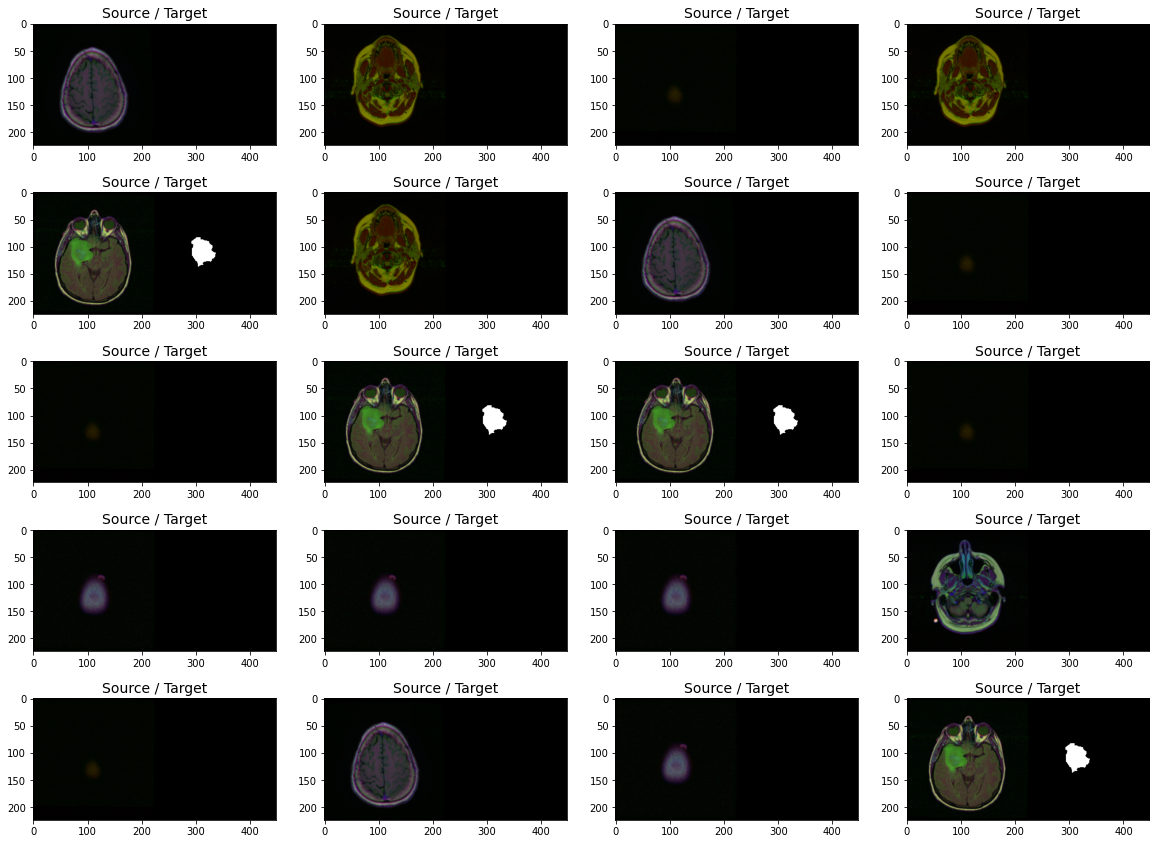

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 15))

for ax in axes.flatten():
    plot_example(loader=test_loader, ax=ax, shape=shape)

## Define Loss Functions

In [ ]:
def dice2(y_pred, y_true, eps=1e-7): 
    #intersect = (y_pred * y_true).sum()
    #return 1 - 2 * (intersect + eps) / (y_pred.sum() + y_true.sum() + eps)

    iflat = y_pred.view(-1)
    tflat = y_true.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + eps) / (iflat.sum() + tflat.sum() + eps))

In [ ]:
def bce_dice(y_pred, y_true):
    dice_loss = dice2(y_pred, y_true)
    bce_score = nn.BCELoss() 
    bce_loss = bce_score(y_pred, y_true)
    loss = nn.BCEWithLogitsLoss()(y_pred, y_true)
    
    return dice_loss + loss
    #return dice_loss + bce_loss
    #return dice_loss
    #return loss

## Train Model

In [ ]:
def make_dirr(name):
    try:
        os.makedirs(name)
    except FileExistsError:
        pass

In [ ]:
def train_model(model, optimizer, epochs, scheduler, train_data_loader, valid_data_loader, early_stopping=5, checkpoint_dirr=f'./checkpoint{1}/'):
    # loss metric
    metrics = defaultdict(list)
    best_loss = np.inf
    
    # for an early stop
    early_count = 0
    
    # directory
    make_dirr(checkpoint_dirr)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        metric = 0
        scheduler.step()
        
        with tqdm(train_data_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            
            for i, (images, target) in enumerate(tepoch):
                # device optimization
                images = images.to(device)
                target = target.to(device) 
                
                # in 64 bits
#                 target = target.long()
                
                # zero out the gradient before backpropagation
                optimizer.zero_grad()
                
                # prediction
                preds = model(images)
                
                # loss function
                loss = bce_dice(preds, target)
                
                # calculate the loss gradient
                loss.backward()
                
                # update settings
                optimizer.step()
                
                # measuring metrics
                train_loss += loss.item()
                
                tepoch.set_postfix(loss=train_loss / (i + 1), lr=scheduler.get_lr()[0])
                
            metrics['loss'].append(train_loss / (i + 1))
            
        # eval mode
        model.eval()
        
        sleep(0.1)

        with torch.no_grad():
            valid_loss = 0
            
            with tqdm(valid_data_loader, unit="batch") as tepoch:
                tepoch.set_description(f"Epoch {epoch}")

                for i, valid_batch in enumerate(tepoch):
                    valid_images, valid_target = valid_batch
                    valid_images = valid_images.to(device)
                    valid_target = valid_target.to(device)
                    
#                     valid_target = valid_target.long()

                    valid_preds = model(valid_images)

                    loss_valid = bce_dice(valid_preds, valid_target)

                    valid_loss += loss_valid.item()

                    tepoch.set_postfix(loss=valid_loss / (i + 1))

                metrics['val_loss'].append(valid_loss / (i + 1))

        sleep(0.1)
        
        if valid_loss < best_loss:
            # resave
            best_loss = valid_loss

            # zero the counter
            early_count = 0

            # save model
            torch.save(model.state_dict(), f'{checkpoint_dirr}epoch:{epoch}.pt')
            print('best model saved')
        else:
            early_count += 1

            if early_count >= early_stopping:
                print(f"Loss did not improve over {early_stopping} epochs => early stopping")
                break

    return model, metrics, checkpoint_dirr

In [ ]:
# model to GPU
model = UNETR().to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.12)

# learning rate scheduler
scheduler = MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.9)

# set epochs
epochs = 100

early_stopping = 8
    
model, losses, dirr = train_model(model=model, optimizer=optimizer, epochs=epochs, scheduler=scheduler, early_stopping=early_stopping,
                                  train_data_loader=train_loader, valid_data_loader=valid_loader)

Epoch 0: 100%|██████████| 63/63 [00:20<00:00,  3.11batch/s, loss=-1.59e+4]


best model saved


Epoch 1: 100%|██████████| 63/63 [00:20<00:00,  3.10batch/s, loss=-1.6e+5]


best model saved


Epoch 2: 100%|██████████| 63/63 [00:19<00:00,  3.16batch/s, loss=-3.59e+5]


best model saved


Epoch 3: 100%|██████████| 63/63 [00:19<00:00,  3.18batch/s, loss=-6.49e+5]


best model saved


Epoch 4: 100%|██████████| 63/63 [00:19<00:00,  3.16batch/s, loss=-9.18e+5]


best model saved


Epoch 5: 100%|██████████| 63/63 [00:20<00:00,  3.14batch/s, loss=-1.14e+6]


best model saved


Epoch 6: 100%|██████████| 63/63 [00:19<00:00,  3.16batch/s, loss=-1.43e+6]


best model saved


Epoch 7: 100%|██████████| 63/63 [00:19<00:00,  3.17batch/s, loss=-1.62e+6]


best model saved


Epoch 8:  82%|████████▏ | 290/355 [04:03<00:54,  1.20batch/s, loss=-1.73e+6, lr=0.0418]

## Evaluate Best Model

In [ ]:
model.load_state_dict(torch.load(f"{dirr}{[name for name in sorted(os.listdir(dirr)) if str(np.argmax(-np.array(losses['val_loss']))) in name][0]}"))
model.eval()

NameError: ignored

In [ ]:
def graph_plot(history, typ=False):
    if typ:
        for i in history.keys():
            print(f'{i} = [{min(history[i])}; {max(history[i])}]\n')
    
    epoch = len(history['loss'])
    # на каждую: (train, val) + lr
    size = len(history.keys()) // 2 + 1

    ncols = 4
    nrows = int(np.ceil(size / ncols))

    
    fig = plt.figure(figsize=(27, 4))
    i = 1
    for k in list(history.keys()):
        if 'val' not in k:
            fig.add_subplot(nrows, ncols, i)
            plt.plot(history[k], marker='o', markersize=5)
            if k != 'lr':
                plt.plot(history['val_' + k], marker='o', markersize=5)
            plt.title(k, fontsize=10)

            plt.ylabel(k)
            plt.xlabel('epoch')
            plt.grid()

            plt.yticks(fontsize=10, rotation=30)
            plt.xticks(fontsize=10, rotation=30)
            plt.legend(['train', 'valid'], loc='upper left', fontsize=10, title_fontsize=15)
            i += 1
#         plt.show()

graph_plot(losses)

In [ ]:
def plot_result(model, loader, ax, shape):
    images, target = next(iter(loader))
    ind = np.random.choice(range(loader.batch_size))
#     try:
#         ind = random.choice([i for i in range(images.shape[0]) if np.max(target[i].permute(1, 2, 0).cpu().detach().numpy()) > 0])
#     except IndexError:
#         images, target = next(iter(loader))
#         ind = random.choice([i for i in range(images.shape[0]) if np.max(target[i].permute(1, 2, 0).cpu().detach().numpy()) > 0])

    pred = model(images[ind].view(1, 3, shape, shape).to(device)).cpu().detach()[0].permute(1, 2, 0).reshape(shape, shape)
    loss = dice2(model(images[ind].view(1, 3, shape, shape).to(device)), target[ind].to(device))
    
    image = images[ind].permute(1, 2, 0)
    target = target[ind].permute(1, 2, 0).reshape(shape, shape)
    target = Image.fromarray(np.asarray(target * 255, dtype=np.uint8)).convert('RGB')
    pred = Image.fromarray(np.asarray(pred * 255, dtype=np.uint8)).convert('RGB')
    
    target = np.asarray(target)
    pred = np.asarray(pred)
    
    ax.imshow(np.hstack([image, target, pred]))
    ax.set_title(f'Source / Target / Prediction ; loss = {round(float(loss), 3)}', fontsize=14)

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(30, 20))

for ax in axes.flatten():
    plot_result(model=model, loader=test_loader, shape=shape, ax=ax)

In [ ]:
loss = 0

for (images, targets) in test_loader:
    images = images.to(device)
    pred = model(images).cpu().detach()
    
    for i, (image, target) in enumerate(zip(images, targets)):
        loss += dice2(pred[i], targets[i])

In [ ]:
loss

In [ ]:
loss / X_test.shape[0]

# Toy Tensor

In [ ]:
a = torch.rand(2,2,3,4)

In [ ]:
a.transpose(-1,-2).shape

torch.Size([5, 2, 4, 3])

In [ ]:
b = a.flatten(2) # flatten last two dimensions
b.shape

torch.Size([5, 2, 12])

In [ ]:
x = torch.rand(32,3,224,224,12,64)
q = torch.rand()
k = torch.rand()
v = torch.rand()

In [ ]:
# 768/12 = 64


In [ ]:
x = torch.rand(3, 32, 32)
x_n = x.size()[:-1] + (12, 64)
x = x.view(*x_n)


RuntimeError: ignored

In [ ]:
rand_image_tensor = torch.randn(32, 3, 224, 224) # batch_size, color_channels, height, width
rand_image_tensor.shape

torch.Size([32, 3, 224, 224])

In [ ]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels, 
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0) 
        # 224/16 => 14
 
        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)
        # (32,768, 14, 14) => (32,768,196)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        print(x_patched.shape)
        x_flattened = self.flatten(x_patched) 
        print(x_flattened.shape)
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, num_patches, P^2•C] # 32, 196, 768

In [ ]:
patch_embedding = PatchEmbedding(patch_size=16)
patch_embedding_output = patch_embedding(rand_image_tensor)
print(f"Input shape: {rand_image_tensor.shape}")
print(f"Output shape: {patch_embedding_output.shape} -> (batch_size, num_patches, embedding_dim)")

torch.Size([32, 768, 14, 14])
torch.Size([32, 768, 196])
Input shape: torch.Size([32, 3, 224, 224])
Output shape: torch.Size([32, 196, 768]) -> (batch_size, num_patches, embedding_dim)


In [ ]:
# (32,196,768)
class SelfAttention(nn.Module):
    def __init__(self, num_heads, embed_dim, dropout):
        super().__init__()
        self.num_attention_heads = num_heads #12
        self.attention_head_size = int(embed_dim / num_heads) # 64
        self.all_head_size = self.num_attention_heads * self.attention_head_size # 768

        self.query = nn.Linear(embed_dim, self.all_head_size)
        self.key = nn.Linear(embed_dim, self.all_head_size)
        self.value = nn.Linear(embed_dim, self.all_head_size) #768,768

        self.out = nn.Linear(embed_dim, embed_dim) # 768,768
        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)

        self.softmax = nn.Softmax(dim=-1)

        self.vis = False

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size) # 32,196,768 => 32,196,12,64
        x = x.view(*new_x_shape) # 32,196,12,64
        return x.permute(0, 2, 1, 3) # 32, 12, 196, 64

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states) # 32, 196, 768 
        mixed_key_layer = self.key(hidden_states) # 32, 196, 768 
        mixed_value_layer = self.value(hidden_states) # 32, 196, 768 

        query_layer = self.transpose_for_scores(mixed_query_layer) # 32, 12, 196, 64
        key_layer = self.transpose_for_scores(mixed_key_layer) # 32, 12, 196, 64
        value_layer = self.transpose_for_scores(mixed_value_layer) # 32, 12, 196, 64

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2)) # 32, 12, 196, 64 @  32, 12, 64, 196 => 32, 12, 196, 196
        attention_scores = attention_scores / math.sqrt(self.attention_head_size) # scale down
        attention_probs = self.softmax(attention_scores) # normalize
        weights = attention_probs if self.vis else None # ?
        attention_probs = self.attn_dropout(attention_probs) # dropout, necassary?

        context_layer = torch.matmul(attention_probs, value_layer) # 32, 12, 196, 196
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights


In [ ]:
x = torch.rand(32, 12, 196, 64)
b = x.transpose(-1,-2)
c = x@b
print(x.shape)
print(b.shape)
print(c.shape)

torch.Size([32, 12, 196, 64])
torch.Size([32, 12, 64, 196])
torch.Size([32, 12, 196, 196])


In [ ]:
v = torch.rand(32,196,768)
d = c@v
d.shape

RuntimeError: ignored

# UNET2D Test // Trash

In [ ]:
# If you are not working on Google Colab, please set the variable to False.

colab = True

if colab:
  from google.colab import drive
  drive.mount('/content/drive/')

if colab:
  import subprocess
  from google.colab import files

  bashCommand = "pip install torch-summary dival"
  process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
  output, error = process.communicate()

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from dival.measure import PSNR, SSIM
from torchsummary import summary

Mounted at /content/drive/


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU", torch.cuda.get_device_name(device))
else:
    device = torch.device("cpu")
    print("Running on CPU")

Running on GPU Tesla T4


In [ ]:
'''
from torchvision import datasets
train_data = datasets.FashionMNIST(
    root='data',
    train=True, 
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transforms=None
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False, 
    download=True,
    transform=ToTensor(),
    target_transforms=None
)
'''

In [ ]:
'''
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()
'''

In [ ]:
'''
from going_modular.going_modular import engine

# Train a pretrained ViT feature extractor
optimizer = torch.optim.Adam(params=UNETR().parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
model=UNETR()

train_data = torch.utils.data.Dataloader(train_dataloader)
test_data = torch.utils.data.Dataloader(test_dataloader)

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_data, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

%%time
# Building a training and testing loop
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building training and evaluation loop
for epoch in range(epochs):
  ### Training
  model.train()

  # Forward pass
  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits -> pred probs -> pred labels

  # Loss
  loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input

  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # optimzer zero grad
  optimizer.zero_grad()

  # backpropagation
  loss.backward()

  # optimizer step (gradient descent)
  optimizer.step()

  # Testing
  model_0.eval()
  with torch.inference_mode():
    # Forward
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Test loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0: 
      print(f'Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%')
'''

In [ ]:
'''
# Get 20% of the data
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

# Setup train and test directories
train_dir_20_percent = data_20_percent_path / "train"
# test_dir_20_percent = data_20_percent_path / "test" # don't need 20% test data as the model in 07. PyTorch Experiment Tracking section 7.3 tests on the 10% dataset not the 20%

# Preprocess the data
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent, 
                                                                                           test_dir=test_dir, # use 10% data for testing
                                                                                          transform=torchvision.transforms.ToTensor(),
                                                                                           batch_size=8)
'''

# Einsum

In [ ]:
a = torch.rand(5,8)
b = torch.rand(2,8)

In [ ]:
c = torch.einsum('ij, kj -> ki',a, b)
c.shape

torch.Size([2, 5])

In [ ]:
query_layer = torch.rand(32, 12, 196, 64)
key_layer = torch.rand(32, 12, 196, 64) 

l = torch.matmul(query_layer, key_layer.transpose(-1, -2))
l.shape

torch.Size([32, 12, 196, 196])

In [ ]:
mixed_query_layer = self.query(hidden_states) # 32, 196, 768 
#print(f'mixed_query_layer: {mixed_query_layer.shape}')
mixed_key_layer = self.key(hidden_states) # 32, 196, 768 
mixed_value_layer = self.value(hidden_states) # 32, 196, 768 

query_layer = self.transpose_for_scores(mixed_query_layer) # 32, 12, 196, 64
key_layer = self.transpose_for_scores(mixed_key_layer) # 32, 12, 196, 64
value_layer = self.transpose_for_scores(mixed_value_layer) # 32, 12, 196, 64

attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2)) # 32, 12, 196, 64 @  32, 12, 64, 196 => 32, 12, 196, 196
#print(f'attention_scores: {attention_scores.shape}') # 1, 12, 196, 196

AxesImage(72,72;446.4x434.88)


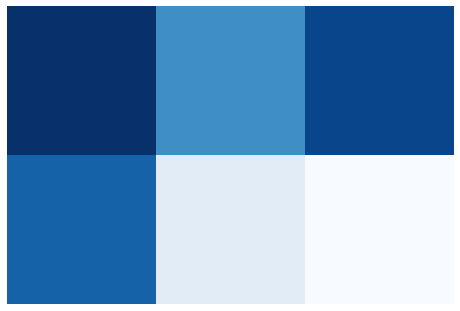

In [ ]:
import matplotlib.pyplot as plt

x = torch.rand(3,2).t()
y = torch.rand(2,3).t()
c = torch.mm(x,y)

plt.figure(figsize=(8,8))

print(plt.imshow(x, cmap='Blues'))
plt.axis(False);

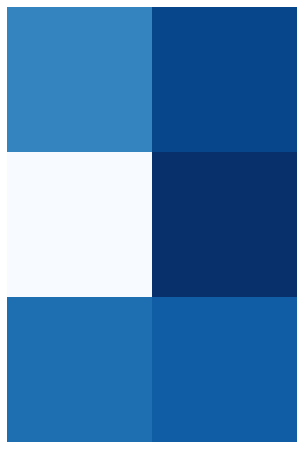

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(y, cmap='Blues')
plt.axis(False);

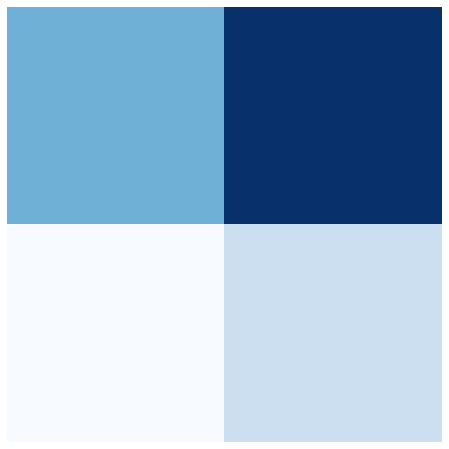

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(c, cmap='Blues')
plt.axis(False);

# Transfer Learning

In [ ]:
# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3435, done.
remote: Total 3435 (delta 0), reused 0 (delta 0), pack-reused 3435
Receiving objects: 100% (3435/3435), 641.56 MiB | 41.45 MiB/s, done.
Resolving deltas: 100% (1975/1975), done.
Updating files: 100% (222/222), done.


In [ ]:
import torchvision

In [ ]:
set_seeds()

In [ ]:
# Create ViT feature extractor model
import torchvision

# Download pretrained ViT weights and model
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" means best available
pretrained_vit = torchvision.models.vit_b_16(weights=vit_weights)

# Freeze all layers in pretrained ViT model 
for param in pretrained_vit.parameters():
  param.requires_grad = False

# Update the preatrained ViT head 
embedding_dim = 768 # ViT_Base
set_seeds()
pretrained_vit.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim, 
              out_features=len(class_names))
)

# Print a summary
summary(model=pretrained_vit, 
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

In [ ]:
# Train a pretrained ViT feature extractor
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_loader,
                                      test_dataloader=valid_loader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)